# Integrating Galactic Orbits

In this example, I will show how to use `tstrippy` to integrate an orbits of the globular clusters in the galaxy

In [1]:
import tstrippy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import numpy as np
import matplotlib.pyplot as plt

## Load the units

In [2]:
unitbasis = tstrippy.Parsers.potential_parameters.unitbasis
unitT=u.Unit(unitbasis['time'])
unitV=u.Unit(unitbasis['velocity'])
unitD=u.Unit(unitbasis['distance'])
unitM=u.Unit(unitbasis['mass'])
unitG=u.Unit(unitbasis['G'])
G = const.G.to(unitG).value

## Load Galactic Parameters

In [3]:
MWparams = tstrippy.Parsers.potential_parameters.pouliasis2017pii()
MWrefframe= tstrippy.Parsers.potential_parameters.MWreferenceframe()

The potential parameters correspond to those of Pouliasis et al 2017. They correspond to the gravitational constant, the Allen and Santillian Halo, a thin disk and a thick disk

In [4]:
params = ["G", "Halo Mass", "Halo scale length", "halo exponential parameter", "cut off radius", "Disk mass", "Disk length", "Disk height","Disk mass", "Disk length", "Disk height"]
for p,name in zip(MWparams,params):
    print("{:.3e} {:s}".format(p,name))

4.301e-06 G
2.088e+11 Halo Mass
1.400e+01 Halo scale length
2.020e+00 halo exponential parameter
1.000e+02 cut off radius
3.712e+10 Disk mass
4.800e+00 Disk length
2.500e-01 Disk height
3.944e+10 Disk mass
2.000e+00 Disk length
8.000e-01 Disk height


The reference frame is an astropy object that is used to convert from skycoordinates to galacocentric coordinates

In [5]:
print("Solar Galactocentric distance", MWrefframe.galcen_distance)
print("Solar velocity", MWrefframe.galcen_v_sun)

Solar Galactocentric distance 8.34 kpc
Solar velocity (11.1, 252.24, 7.25) km / s


## Load the Globular Clusters
Store them in an astropy object to store them to galactocentric coordinates

In [6]:
GCdata  =   tstrippy.Parsers.baumgardtMWGCs().data
skycoordinates=coord.SkyCoord(
    ra=GCdata['RA'],
    dec=GCdata['DEC'],
    distance=GCdata['Rsun'],
    pm_ra_cosdec=GCdata['mualpha'],
    pm_dec=GCdata['mu_delta'],
    radial_velocity=GCdata['RV'],)
galacticcoordinates = skycoordinates.transform_to(MWrefframe)
x,y,z=galacticcoordinates.cartesian.xyz.to(unitD).value
vx,vy,vz=galacticcoordinates.velocity.d_xyz.to(unitV).value
# grab the number of objects
Nobj=len(x)

## Set integration time

Do this in years so that you can assure the number of timesteps is an integer, and then convert the total time *T* and the timestep *dt* into integration units.

In [7]:
T,dt = 1e9,1e6
Ntimestep=int(T/dt)
T,dt=T*u.yr,dt*u.yr
T,dt=T.to(unitT),dt.to(unitT)
t=np.arange(0,T.value,dt.value) # an array of time for later use

## Initialize the integrator

In [8]:
tstrippy.integrator.setstaticgalaxy("pouliasis2017pii",MWparams)
tstrippy.integrator.setinitialkinematics(x,y,z,vx,vy,vz)
tstrippy.integrator.setintegrationparameters(T.value,dt.value,Ntimestep)
xt,yt,zt,vxt,vyt,vzt=tstrippy.integrator.leapfrogintime(Ntimestep,Nobj)
tstrippy.integrator.deallocate()

## Plot the results

In [9]:
# give each object a color 
import matplotlib.cm as cm
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})
colors = cm.rainbow(np.linspace(0, 1, Nobj))
AXIS = {"xlabel":"X [kpc]","ylabel":"Y [kpc]","zlabel":"Z [kpc]","aspect":"equal",}

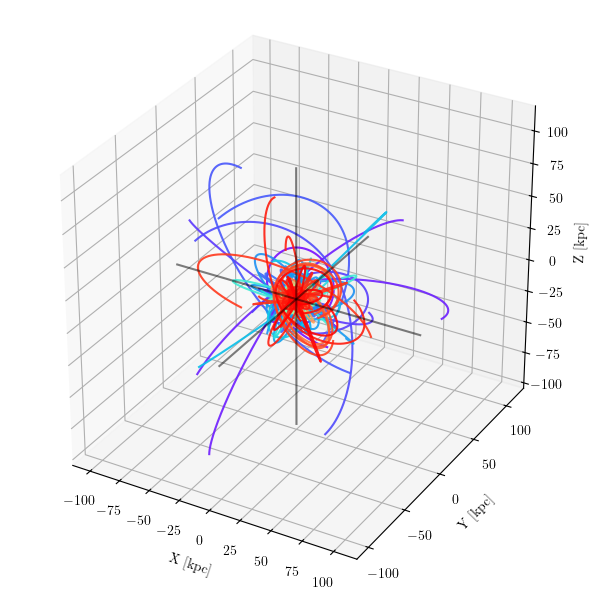

In [10]:
fig=plt.figure(figsize=(6,6))
axis=fig.add_subplot(111,projection='3d')
for i in range(Nobj):
    axis.plot(xt[i],yt[i],zt[i],color=colors[i],alpha=0.9)
axis.set(**AXIS)
axis.plot([-100,100],[0,0],[0,0],color='black',linestyle='-',alpha=0.5)
axis.plot([0,0],[-100,100],[0,0],color='black',linestyle='-',alpha=0.5)
axis.plot([0,0],[0,0],[-100,100],color='black',linestyle='-',alpha=0.5)
# turn off axis panes
fig.tight_layout()